<a href="https://colab.research.google.com/github/mrkdh16/lottery-ticket-exploration/blob/main/LTH_OOD_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I aim to test the functional lottery ticket hypothesis presented in [Zhang et al](https://proceedings.mlr.press/v139/zhang21a/zhang21a.pdf): "[for any full network] there exists a subnetwork that can achieve better OOD and commensurate in-distribution accuracy in a comparable number of iterations when trained in isolation" using the [MNIST-1D dataset](https://github.com/greydanus/mnist1d?tab=readme-ov-file).

Much of the code in this notebook is borrowed from an [example notebook](https://github.com/greydanus/mnist1d/blob/master/notebooks/lottery-tickets.ipynb) from the [MNIST-1D repo](https://github.com/greydanus/mnist1d?tab=readme-ov-file).

In [1]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master
!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-zf43sgrw
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-zf43sgrw
  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=f78c8c9cb80546cf9253ad65bc37f4011ea6f731821ae997c813cad7867606ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-7sy0fi18/wheels/7e/c4/e4/1c3e9af5ba2f0004e7850f6070dc4a1c896852c8ac5ca5bb6a
Successfully built mnist1d
Cloning into 'mnist1d'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 541 (delta 67), reused 66 (delta 66), pack-reuse

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [3]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Mounted at /content/gdrive


In [4]:
from mnist1d.data import get_dataset, get_dataset_args, make_dataset
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('./mnist1d/notebooks')
from train import get_model_args, train_model

In [5]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec).to(DEVICE)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

  # find a mask, given some heuristic and desired sparsity
def get_mask(scores, percent_sparse):
  # scores: per-weight scores for determining which weights to drop
  # percent_sparse: how much to sparsify the model
  num_to_drop = int(percent_sparse * len(scores))
  ixs_to_drop = torch.sort(scores)[1][:num_to_drop] # sort from low score to high, select k with lowest score
  mask = torch.ones_like(scores)
  mask[ixs_to_drop] = 0
  return mask

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [7]:
def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)

In [8]:
def train_model(dataset, model, args):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), args.learning_rate, weight_decay=args.weight_decay)

  x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test'])
  y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])

  model = model.to(args.device)
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  results = {'checkpoints':[], 'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[]}
  # t0 = time.time()
  for step in range(args.total_steps+1):
      bix = (step*args.batch_size)%len(x_train) # batch index
      x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]

      loss = criterion(model(x), y)
      results['train_losses'].append(loss.item())
      loss.backward() ; optimizer.step() ; optimizer.zero_grad()

      if args.eval_every > 0 and step % args.eval_every == 0: # evaluate the model
          test_loss = criterion(model(x_test), y_test)
          results['test_losses'].append(test_loss.item())
          results['train_acc'].append(accuracy(model, x_train, y_train))
          results['test_acc'].append(accuracy(model, x_test, y_test))

      # if step > 0 and step % args.print_every == 0: # print out training progress
      #     t1 = time.time()
      #     print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
      #         .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
      #                 results['train_acc'][-1], results['test_acc'][-1]))
      #     t0 = t1

      # if args.checkpoint_every > 0 and step % args.checkpoint_every == 0: # save model checkpoints
      #     model.step = step
      #     results['checkpoints'].append( copy.deepcopy(model) )
  results['checkpoints'].append(copy.deepcopy(model))
  return results

In [9]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None,
                        prune_print_every=None, seed=None, **kwargs):
  if seed is not None:
    set_seed(seed)

  if prune_print_every is None:
    prune_print_every = np.inf

  if criteria_fn is None:
    print("Using default magnitude-based pruning")
    criteria_fn = lambda init_params, final_params: final_params.abs()

  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % prune_print_every == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

In [10]:
# train settings
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000 # print never
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.device = DEVICE

# sparsity settings
num_retrains = 100
sparsity_schedule = np.linspace(0,1.,num_retrains) #1-np.cumprod(np.ones(num_retrains)*tau)/tau # tau = .97

In [11]:
args = get_dataset_args()
data = get_dataset(args=args)

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl


In [12]:
num_trials = 10
trials = {'lott_models': [], 'lott_stats': []}
for t in tqdm(range(num_trials)):
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size).to(DEVICE)

  criteria_fn = lambda init_params, final_params: final_params.abs()
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                  criteria_fn=criteria_fn, prune_print_every=1)
  trials['lott_models'].append(models)
  trials['lott_stats'].append(stats)

  0%|          | 0/10 [00:00<?, ?it/s]

	retrain #1, sparsity 0.00, final_train_loss 1.197e-01, max_acc 64.4, last_acc 63.3, mean_acc 57.3
	retrain #2, sparsity 0.01, final_train_loss 7.553e-02, max_acc 65.1, last_acc 63.6, mean_acc 57.9
	retrain #3, sparsity 0.02, final_train_loss 1.028e-01, max_acc 64.6, last_acc 63.3, mean_acc 57.7
	retrain #4, sparsity 0.03, final_train_loss 5.844e-02, max_acc 65.8, last_acc 64.9, mean_acc 57.5
	retrain #5, sparsity 0.04, final_train_loss 1.493e-01, max_acc 64.7, last_acc 62.5, mean_acc 57.3
	retrain #6, sparsity 0.05, final_train_loss 1.409e-01, max_acc 67.0, last_acc 64.8, mean_acc 57.8
	retrain #7, sparsity 0.06, final_train_loss 1.754e-01, max_acc 66.7, last_acc 65.5, mean_acc 57.8
	retrain #8, sparsity 0.07, final_train_loss 1.326e-01, max_acc 65.6, last_acc 64.8, mean_acc 57.9
	retrain #9, sparsity 0.08, final_train_loss 3.187e-01, max_acc 65.0, last_acc 65.0, mean_acc 57.9
	retrain #10, sparsity 0.09, final_train_loss 2.852e-01, max_acc 65.0, last_acc 65.0, mean_acc 58.1
	retrain 

 10%|█         | 1/10 [05:05<45:47, 305.25s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 1.844e-01, max_acc 66.4, last_acc 66.4, mean_acc 57.6
	retrain #2, sparsity 0.01, final_train_loss 3.647e-01, max_acc 64.4, last_acc 63.7, mean_acc 57.6
	retrain #3, sparsity 0.02, final_train_loss 1.759e-01, max_acc 64.9, last_acc 64.9, mean_acc 58.1
	retrain #4, sparsity 0.03, final_train_loss 1.859e-01, max_acc 64.6, last_acc 64.1, mean_acc 57.1
	retrain #5, sparsity 0.04, final_train_loss 3.141e-01, max_acc 65.1, last_acc 65.0, mean_acc 57.9
	retrain #6, sparsity 0.05, final_train_loss 1.357e-01, max_acc 66.0, last_acc 66.0, mean_acc 57.8
	retrain #7, sparsity 0.06, final_train_loss 2.924e-01, max_acc 65.7, last_acc 62.3, mean_acc 57.9
	retrain #8, sparsity 0.07, final_train_loss 1.590e-01, max_acc 66.0, last_acc 66.0, mean_acc 58.6
	retrain #9, sparsity 0.08, final_train_loss 1.490e-01, max_acc 65.9, last_acc 64.9, mean_acc 58.2
	retrain

 20%|██        | 2/10 [10:03<40:09, 301.22s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 2.723e-01, max_acc 64.8, last_acc 64.8, mean_acc 57.2
	retrain #2, sparsity 0.01, final_train_loss 1.989e-01, max_acc 70.3, last_acc 70.3, mean_acc 58.7
	retrain #3, sparsity 0.02, final_train_loss 1.975e-01, max_acc 66.1, last_acc 66.1, mean_acc 58.0
	retrain #4, sparsity 0.03, final_train_loss 1.505e-01, max_acc 66.0, last_acc 66.0, mean_acc 57.6
	retrain #5, sparsity 0.04, final_train_loss 1.813e-01, max_acc 63.8, last_acc 62.4, mean_acc 57.6
	retrain #6, sparsity 0.05, final_train_loss 1.423e-01, max_acc 66.1, last_acc 66.1, mean_acc 58.5
	retrain #7, sparsity 0.06, final_train_loss 2.847e-01, max_acc 65.9, last_acc 63.5, mean_acc 57.5
	retrain #8, sparsity 0.07, final_train_loss 6.281e-02, max_acc 66.6, last_acc 66.5, mean_acc 57.7
	retrain #9, sparsity 0.08, final_train_loss 2.096e-01, max_acc 64.4, last_acc 63.7, mean_acc 57.8
	retrain

 30%|███       | 3/10 [15:02<35:02, 300.35s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 1.386e-01, max_acc 65.5, last_acc 63.1, mean_acc 57.4
	retrain #2, sparsity 0.01, final_train_loss 8.818e-02, max_acc 65.8, last_acc 63.3, mean_acc 57.6
	retrain #3, sparsity 0.02, final_train_loss 1.302e-01, max_acc 64.9, last_acc 64.4, mean_acc 57.8
	retrain #4, sparsity 0.03, final_train_loss 1.715e-01, max_acc 65.0, last_acc 65.0, mean_acc 57.7
	retrain #5, sparsity 0.04, final_train_loss 1.223e-01, max_acc 65.1, last_acc 63.0, mean_acc 57.3
	retrain #6, sparsity 0.05, final_train_loss 2.915e-01, max_acc 66.8, last_acc 63.1, mean_acc 57.9
	retrain #7, sparsity 0.06, final_train_loss 1.010e-01, max_acc 64.1, last_acc 64.1, mean_acc 57.3
	retrain #8, sparsity 0.07, final_train_loss 3.214e-01, max_acc 65.9, last_acc 64.9, mean_acc 58.2
	retrain #9, sparsity 0.08, final_train_loss 1.652e-01, max_acc 65.9, last_acc 65.9, mean_acc 58.0
	retrain

 40%|████      | 4/10 [20:03<30:01, 300.25s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 1.049e-01, max_acc 66.2, last_acc 66.2, mean_acc 57.9
	retrain #2, sparsity 0.01, final_train_loss 4.658e-01, max_acc 65.5, last_acc 62.8, mean_acc 57.3
	retrain #3, sparsity 0.02, final_train_loss 1.450e-01, max_acc 66.8, last_acc 66.8, mean_acc 58.1
	retrain #4, sparsity 0.03, final_train_loss 2.683e-01, max_acc 65.2, last_acc 64.6, mean_acc 57.3
	retrain #5, sparsity 0.04, final_train_loss 3.605e-01, max_acc 67.0, last_acc 63.9, mean_acc 58.4
	retrain #6, sparsity 0.05, final_train_loss 1.138e-01, max_acc 67.5, last_acc 67.5, mean_acc 57.6
	retrain #7, sparsity 0.06, final_train_loss 2.643e-01, max_acc 65.5, last_acc 63.4, mean_acc 58.1
	retrain #8, sparsity 0.07, final_train_loss 2.251e-01, max_acc 65.1, last_acc 65.0, mean_acc 58.5
	retrain #9, sparsity 0.08, final_train_loss 2.106e-01, max_acc 66.6, last_acc 65.6, mean_acc 59.2
	retrain

 50%|█████     | 5/10 [25:04<25:03, 300.78s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 1.922e-01, max_acc 64.9, last_acc 63.4, mean_acc 58.0
	retrain #2, sparsity 0.01, final_train_loss 2.794e-01, max_acc 65.0, last_acc 64.5, mean_acc 58.0
	retrain #3, sparsity 0.02, final_train_loss 2.600e-01, max_acc 66.0, last_acc 66.0, mean_acc 57.7
	retrain #4, sparsity 0.03, final_train_loss 2.811e-01, max_acc 65.6, last_acc 64.6, mean_acc 58.4
	retrain #5, sparsity 0.04, final_train_loss 3.241e-01, max_acc 64.6, last_acc 63.2, mean_acc 57.5
	retrain #6, sparsity 0.05, final_train_loss 1.764e-01, max_acc 66.0, last_acc 65.9, mean_acc 58.2
	retrain #7, sparsity 0.06, final_train_loss 7.369e-02, max_acc 65.8, last_acc 65.8, mean_acc 58.6
	retrain #8, sparsity 0.07, final_train_loss 1.719e-01, max_acc 65.9, last_acc 63.4, mean_acc 58.1
	retrain #9, sparsity 0.08, final_train_loss 2.359e-01, max_acc 65.5, last_acc 62.5, mean_acc 57.9
	retrain

 60%|██████    | 6/10 [30:06<20:04, 301.07s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 4.212e-01, max_acc 64.7, last_acc 64.7, mean_acc 57.2
	retrain #2, sparsity 0.01, final_train_loss 2.284e-01, max_acc 66.1, last_acc 64.6, mean_acc 57.9
	retrain #3, sparsity 0.02, final_train_loss 2.530e-01, max_acc 63.6, last_acc 63.5, mean_acc 57.0
	retrain #4, sparsity 0.03, final_train_loss 2.225e-01, max_acc 66.3, last_acc 66.3, mean_acc 58.0
	retrain #5, sparsity 0.04, final_train_loss 2.337e-01, max_acc 65.2, last_acc 65.2, mean_acc 57.9
	retrain #6, sparsity 0.05, final_train_loss 3.657e-01, max_acc 65.9, last_acc 63.1, mean_acc 58.2
	retrain #7, sparsity 0.06, final_train_loss 3.392e-01, max_acc 64.9, last_acc 64.2, mean_acc 57.5
	retrain #8, sparsity 0.07, final_train_loss 1.517e-01, max_acc 66.5, last_acc 65.8, mean_acc 58.7
	retrain #9, sparsity 0.08, final_train_loss 1.475e-01, max_acc 65.3, last_acc 65.3, mean_acc 58.0
	retrain

 70%|███████   | 7/10 [35:04<14:59, 299.97s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 2.214e-01, max_acc 66.9, last_acc 65.0, mean_acc 57.8
	retrain #2, sparsity 0.01, final_train_loss 4.172e-01, max_acc 64.5, last_acc 64.0, mean_acc 57.6
	retrain #3, sparsity 0.02, final_train_loss 1.865e-01, max_acc 64.4, last_acc 63.2, mean_acc 57.1
	retrain #4, sparsity 0.03, final_train_loss 1.610e-01, max_acc 67.1, last_acc 67.1, mean_acc 58.0
	retrain #5, sparsity 0.04, final_train_loss 4.005e-01, max_acc 64.7, last_acc 62.6, mean_acc 57.8
	retrain #6, sparsity 0.05, final_train_loss 1.745e-01, max_acc 65.5, last_acc 65.5, mean_acc 57.8
	retrain #7, sparsity 0.06, final_train_loss 2.600e-01, max_acc 65.6, last_acc 64.2, mean_acc 57.8
	retrain #8, sparsity 0.07, final_train_loss 1.551e-02, max_acc 68.8, last_acc 68.8, mean_acc 58.4
	retrain #9, sparsity 0.08, final_train_loss 3.691e-02, max_acc 66.3, last_acc 66.3, mean_acc 58.4
	retrain

 80%|████████  | 8/10 [40:02<09:58, 299.32s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 1.087e-01, max_acc 66.0, last_acc 66.0, mean_acc 57.8
	retrain #2, sparsity 0.01, final_train_loss 2.931e-01, max_acc 64.1, last_acc 62.5, mean_acc 57.1
	retrain #3, sparsity 0.02, final_train_loss 1.296e-01, max_acc 65.4, last_acc 64.8, mean_acc 58.3
	retrain #4, sparsity 0.03, final_train_loss 2.576e-01, max_acc 67.7, last_acc 67.7, mean_acc 58.0
	retrain #5, sparsity 0.04, final_train_loss 1.508e-01, max_acc 65.5, last_acc 65.3, mean_acc 58.4
	retrain #6, sparsity 0.05, final_train_loss 2.128e-01, max_acc 66.2, last_acc 64.9, mean_acc 58.1
	retrain #7, sparsity 0.06, final_train_loss 2.517e-01, max_acc 65.9, last_acc 64.8, mean_acc 59.2
	retrain #8, sparsity 0.07, final_train_loss 1.626e-01, max_acc 65.7, last_acc 63.9, mean_acc 58.2
	retrain #9, sparsity 0.08, final_train_loss 1.619e-01, max_acc 65.4, last_acc 65.3, mean_acc 57.8
	retrain

 90%|█████████ | 9/10 [45:00<04:58, 298.92s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain #1, sparsity 0.00, final_train_loss 2.934e-01, max_acc 63.1, last_acc 62.2, mean_acc 56.7
	retrain #2, sparsity 0.01, final_train_loss 1.755e-01, max_acc 64.1, last_acc 62.7, mean_acc 57.0
	retrain #3, sparsity 0.02, final_train_loss 1.666e-01, max_acc 64.4, last_acc 64.4, mean_acc 57.6
	retrain #4, sparsity 0.03, final_train_loss 1.684e-01, max_acc 66.4, last_acc 66.4, mean_acc 57.7
	retrain #5, sparsity 0.04, final_train_loss 2.220e-01, max_acc 63.7, last_acc 63.7, mean_acc 57.3
	retrain #6, sparsity 0.05, final_train_loss 1.608e-01, max_acc 64.6, last_acc 64.4, mean_acc 57.5
	retrain #7, sparsity 0.06, final_train_loss 3.806e-01, max_acc 66.3, last_acc 64.5, mean_acc 58.2
	retrain #8, sparsity 0.07, final_train_loss 3.124e-01, max_acc 65.5, last_acc 65.0, mean_acc 58.6
	retrain #9, sparsity 0.08, final_train_loss 2.367e-01, max_acc 63.8, last_acc 60.9, mean_acc 57.7
	retrain

100%|██████████| 10/10 [49:58<00:00, 299.84s/it]

	retrain #100, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2


In [13]:
to_pickle(trials, path=project_dir + 'lottery.pkl')  # cache results because they take awhile (~1hr) to compute

In [12]:
trials = from_pickle(path=project_dir + 'lottery.pkl')   # optionally load precomputed results from your Drive

In [15]:
!pip install scienceplots

In [20]:
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

In [28]:
def evaluate_ensemble(models, dataset, device):
  inputs = torch.tensor(dataset['x_test'], dtype=torch.float32).to(device)
  labels = torch.tensor(dataset['y_test'], dtype=torch.int64).to(device)
  test_dataset = TensorDataset(inputs, labels)
  test_loader = DataLoader(test_dataset, batch_size=model_args.batch_size, shuffle=False)

  correct_predictions = 0
  total_samples = 0

  for inputs, labels in test_loader:
    local_outputs = []
    for model in models:
      model.eval()
      local_outputs.append(model(inputs))
    avg_outputs = torch.stack(local_outputs).mean(0)
    _, predicted = torch.max(avg_outputs, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

  accuracy = (correct_predictions / total_samples) * 100
  return accuracy

In [29]:
ensemble_accs = []
for sparsity in tqdm(np.linspace(0,1.,num_retrains)):
  models = []
  for model in trials['lott_models']:
    models.append(model[int(sparsity*len(model))-1])
  ensemble_accs.append(evaluate_ensemble(models, data, DEVICE))

100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


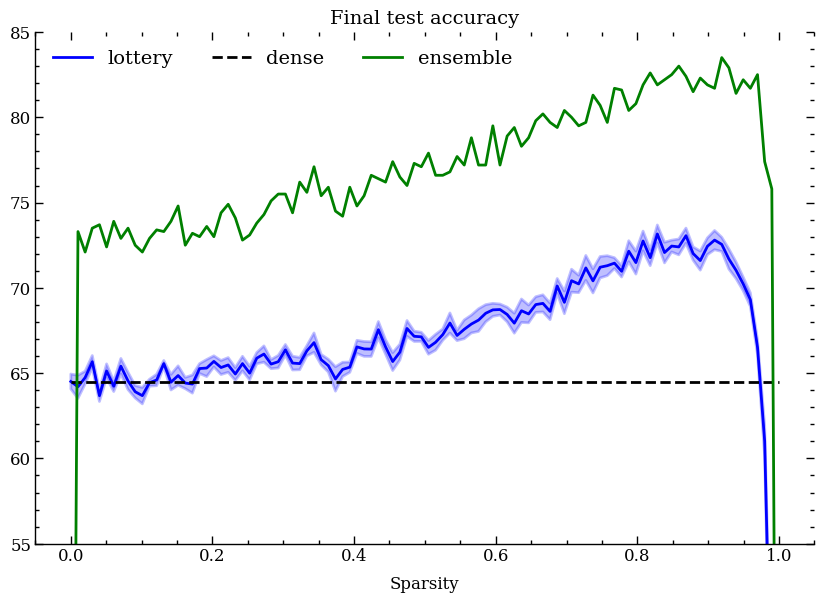

In [32]:
def average_over(trials, trial_name, key):
  ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
  return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))

x = sparsity_schedule
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[8,3], dpi=200)

plt.subplot(1,2,2)
y, y_err = average_over(trials, 'lott_stats', 'test_accs')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.plot(x,ensemble_accs,'-',color='green',label='ensemble')
plt.xlabel('Sparsity') ; plt.title('Final test accuracy')
plt.ylim(55, 85) #plt.ylim(70, 85)
plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.show()

# os.makedirs(project_dir + 'figures/', exist_ok=True)
# fig.savefig(project_dir + 'figures/lottery.png')
# fig.savefig(project_dir + 'figures/lottery.pdf')